<a href="https://colab.research.google.com/github/Guche02/transformer-from-scratch/blob/master/transformers_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import math

 ## Input Embeddings: convert tokens into vector of 512 dimensions.

nn.module is the base class for all creating all the neural networks.


 The models that we create, inherit the functions from this base class such as forward() function.

  super() is used to initialize the parent class ( nn.module ) by every object that is created later.  *If super() is not used that methods like nn.Embedding will not be initialzed and we will not be able to use it.*


In [2]:
class InputEmbeddings(nn.Module):
  def __init__(self, d_model: int, vocab_size:int):
    super().__init__()
    self.d_model = d_model
    self.vocab_size = vocab_size
    self.embedding = nn.Embedding(num_embeddings = vocab_size, embedding_dim = d_model)

  def forward(self, x):
    return self.embedding(x) * math.sqrt(self.d_model)   # embedding is multiplied by d_model according to the original paper.

## Positional Encoding: add information about position of tokens

Dropout is used in positional encoding to prevent the over-reliance on the positions of tokens. Instead, the model is made to focus on the semantic relationships between the tokens.

 torch.arrange() is similar to range() in python.
  
  unsqueeze() is used to add an extra dimenion at the specified position.
   
  all the numbers are converted to float(), to avoid broadcasting to int by mistake during division.

  register_buffer() is added to register a tensor as a buffer (part of the model but not considered a model parameter (i.e., it does not get updated during training))

  requires_grad(false) means that the parameter is not updated during training.
  

In [3]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model: int, seq_len: int, dropout:float):
    super().__init__()
    self.d_model = d_model
    self.seq_len = seq_len
    self.dropout = nn.Dropout(dropout)

    # create a tensor (seq_len x d_model) filled with zeros as a placeholder for positional encoding
    pe = torch.zeros(seq_len, d_model)

    # numerator term of the formula for positional encoding
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)

    # denominator term of the formula
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))  # log and exp is used for numerical stability.

    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    # adding a batch size dimension to positional encoding, specifying that this positional encoding is used for single ip sequence
    pe = pe.unsqueeze(0)  # (1, seq_len, d_model)

    # saving the positional encoding info as a constant buffer that is not updated during training.
    self.register_buffer('pe', pe)

  def forward(self, x):
    # x.shape[1] gives the length of ip sequqnce.
    x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
    return self.dropout(x)

### Layer Normalization : normalizing the values across the features.

layer norm = alpha * (x - mean/std) + bias

-1 is used in x.mean to denote that mean is taken across last dimensions ( across the features(columns) and not the batch(rows) in this case.

keep_dims is used to preserve the original dimension.

nn.parameter is used to specify that the parameter is learnable during training

In [4]:
class LayerNorm(nn.Module):
  def __init__(self, eps):
    super().__init__()
    self.eps = eps
    self.alpha = nn.Parameter(torch.ones(1))  # default initial value is chosen as 1
    self.bias = nn.Parameter(torch.zeros(1))  # default initial value is chosen as 0

  def forward(self, x):
    mean = x.mean(-1, keepdims = True)
    std = x.std(-1, keepdims = True)
    return ((x - mean) / (std + self.eps)) * self.alpha + self.bias

### Feed forward layer: Two linear transformations wit ReLU activation in between according to the original paper

According the original paper d_ff = 2048 and d_model = 512

In [5]:
class FeedForward(nn.Module):
  def __init__(self, d_model: int, d_ff: int, dropout: float):
    super().__init__()
    self.d_model = d_model
    self.d_ff = d_ff
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    x = nn.Linear(self.d_model, self.d_ff)
    x = nn.ReLU(x)
    x = self.dropout(x)
    x = nn.Linear(self.d_ff, self.d_model)
    x = self.dropout(x)
    return x

### Multihead attention: 1 sequence is divided into Query, Key and Value and attention score is calculated
In case of encoder, the input is duplicated in Q,K,V.

In case of different heads, each head will have access to all the input sequence but only some portions of the embedding. (seq_len, d_model)

d_model must be divisible by h to divide the dimension equally into different heads.


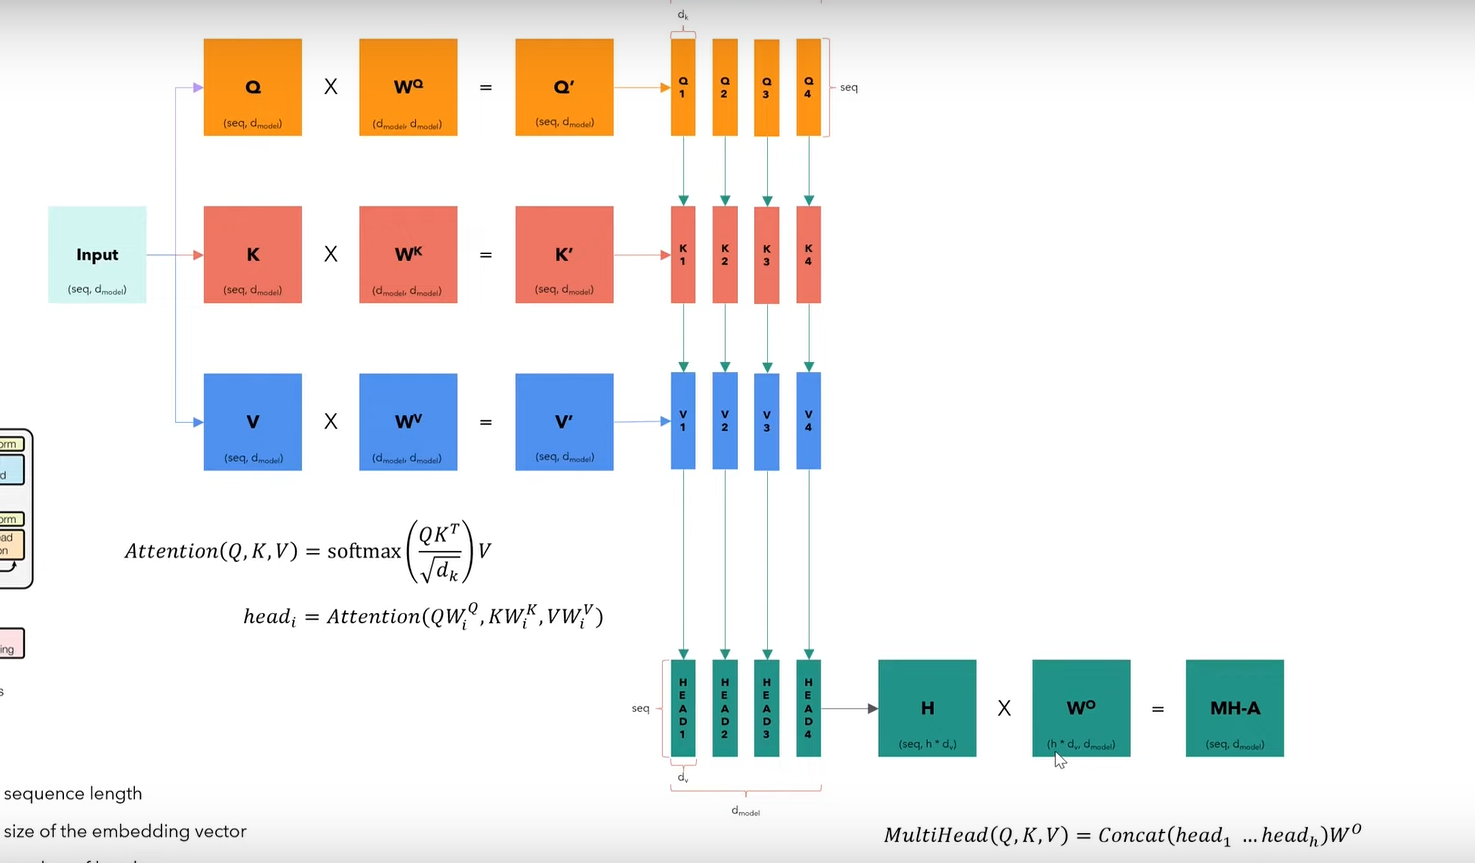

In [6]:
class MultiheadAttention(nn.Module):
  def __init__(self, d_model: int, h: int, dropout: float):  # h is the number of heads
    super().__init__()
    self.d_model = d_model
    self.h = h
    assert d_model % h == 0, "d_model is not divisible by h"

    self.d_k = d_model // h
    self.w_k = nn.Linear(d_model, d_model)   # nn.Linear has default weight initialization as learnable parameter
    self.w_q = nn.Linear(d_model, d_model)
    self.w_v = nn.Linear(d_model, d_model)
    self.w_o = nn.Linear(d_model, d_model)   # d_v * h is d_model
    self.dropout = nn.Dropout(dropout)

  # Declaring self_attention as a static method avoids the need to create an instance of the class to use it
  @staticmethod
  def selfAttention(query, key, value, mask, dropout):
    d_k = query.shape[-1]
    # @ represents matrix multiplication
    attention_score = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)  # (batch_size, h, seq_len, seq_len)
    if mask is not None:
      attention_score = attention_score.masked_fill(mask == 0, -1e9)   # if mask == 0, then replace by -1e9
    attention_score = torch.softmax(attention_score, dim=-1)  # the result of multiplication across a sequence is present in the last dimension
    if dropout is not None:
      attention_score = dropout(attention_score)
    # att_score @ value is the output of self_attention
    return (attention_score @ value), attention_score

  def forward(self, q, k, v, mask):   # mask is used to mask attention of some words with other words
    query = self.w_q(q)
    key = self.w_k(k)
    value = self.w_v(v)  # (batch, seq, d_model)

    # .view() method is used to change the shape of the data
    # .transpose(1,2) swaps two positions 1 and 2..we do this to change into desirable format of (seq_len, d_k)
    query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1,2)
    key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1,2)
    value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1,2)   # (batch, h, seq_len, d_k)

    x, attention_scores = MultiheadAttention.selfAttention(query, key, value, mask, self.dropout)

    # (Batch, h, seq_len, d_k) --> (Batch, seq_len, h, d_k) --> (Batch, seq_len, d_model)
    x = x.transpose(1,2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

    return self.w_o(x)

### Residual Connection: skip one layer and provide the input to another layer

In [7]:
class ResidualConnection(nn.Module):
  def __init__(self, dropout: float):
    super().__init__()
    self.dropout = nn.Dropout(dropout)
    self.norm = LayerNorm()

  def forward(self, x, sublayer):
    return x + self.dropout(sublayer(self.norm(x)))